In [22]:
import string
import numpy as np
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
from tensorflow.keras.optimizers.legacy import RMSprop
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [23]:
data_path = 'por-eng/por_new.txt'
with open(data_path, 'r', encoding = 'utf-8') as f:
    lines = f.read()
    
lines[0:100]

'Go.\tVai.\nGo.\tVá.\nHi.\tOi.\nRun!\tCorre!\nRun!\tCorra!\nRun!\tCorram!\nRun.\tCorre!\nRun.\tCorra!\nRun.\tCorram!\nW'

In [24]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [25]:
por_eng = to_lines(lines)
por_eng[:5]

[['Go.', 'Vai.'],
 ['Go.', 'Vá.'],
 ['Hi.', 'Oi.'],
 ['Run!', 'Corre!'],
 ['Run!', 'Corra!']]

In [26]:
por_eng = array(por_eng)
por_eng[:5]

array([['Go.', 'Vai.'],
       ['Go.', 'Vá.'],
       ['Hi.', 'Oi.'],
       ['Run!', 'Corre!'],
       ['Run!', 'Corra!']], dtype='<U275')

In [27]:
por_eng.shape

(190639, 2)

In [28]:
por_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in por_eng[:,0]]
por_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in por_eng[:,1]]

por_eng[:5]

array([['Go', 'Vai'],
       ['Go', 'Vá'],
       ['Hi', 'Oi'],
       ['Run', 'Corre'],
       ['Run', 'Corra']], dtype='<U275')

In [29]:
for i in range(len(por_eng)):
    por_eng[i,0] = por_eng[i,0].lower()
    por_eng[i,1] = por_eng[i,1].lower()
por_eng

array([['go', 'vai'],
       ['go', 'vá'],
       ['hi', 'oi'],
       ...,
       ['a child who is a native speaker usually knows many things about his or her language that a nonnative speaker who has been studying for years still does not know and perhaps will never know',
        'uma criança que é falante nativa geralmente sabe muitas coisas sobre sua língua que um falante nãonativo que tem estudado há anos ainda não sabe e talvez nunca saberá'],
       ['tales of gentleness of honor of justice of courage of fortitude in suffering of intrepidity in danger of dauntless resolution of iron will inspire children to an emulation of those virtues',
        'contos de docilidade de honra de justiça de coragem de fortaleza perante o sofrimento de intrepidez perante o perigo de resolução destemida de vontade de ferro inspiram as crianças a uma emulação dessas virtudes'],
       ['using high heat settings while ironing synthetic fabrics will melt the synthetic fibers and cause visible perman

In [30]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# prepare english tokenizer
eng_tokenizer = tokenization(por_eng[:,0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 13550


In [31]:
# prepare portuguese tokenizer
por_tokenizer = tokenization(por_eng[:, 1])
por_vocab_size = len(por_tokenizer.word_index) + 1

por_length = 8
print('Portuguese Vocabulary Size: %d' % por_vocab_size)

Portuguese Vocabulary Size: 23770


In [32]:
def encode_sequences(tokenizer, length, lines):
    #integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    #pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [33]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(por_eng, test_size = 0.2, random_state=12)

In [34]:
# prepare training data
trainX = encode_sequences(por_tokenizer, por_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation
testX = encode_sequences(por_tokenizer, por_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])


In [35]:
# built NMT model
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero = True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units,return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [41]:
#RMSprop optimizer

# model compilation

model = define_model(por_vocab_size, eng_vocab_size, por_length, eng_length, 64)
# rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [43]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1],1),
                    epochs=10,batch_size = 64, validation_split = 0.2)


Epoch 1/10
1907/1907 [==============================] - 74s 38ms/step - loss: 4.4630 - accuracy: 0.3318 - val_loss: 4.1066 - val_accuracy: 0.3608
Epoch 2/10
1907/1907 [==============================] - 72s 38ms/step - loss: 3.8559 - accuracy: 0.3912 - val_loss: 3.6908 - val_accuracy: 0.4124
Epoch 3/10
1907/1907 [==============================] - 73s 38ms/step - loss: 3.5423 - accuracy: 0.4289 - val_loss: 3.4715 - val_accuracy: 0.4404
Epoch 4/10
1907/1907 [==============================] - 72s 38ms/step - loss: 3.3165 - accuracy: 0.4589 - val_loss: 3.2810 - val_accuracy: 0.4646
Epoch 5/10
1907/1907 [==============================] - 71s 37ms/step - loss: 3.1466 - accuracy: 0.4800 - val_loss: 3.1458 - val_accuracy: 0.4822
Epoch 6/10
1907/1907 [==============================] - 71s 37ms/step - loss: 3.0288 - accuracy: 0.4961 - val_loss: 3.0707 - val_accuracy: 0.4911
Epoch 7/10
1907/1907 [==============================] - 75s 39ms/step - loss: 2.9263 - accuracy: 0.5098 - val_loss: 2.9935 -

In [44]:
print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])


Training Accuracy: 0.538392961025238
Validation Accuracy: 0.5233132839202881


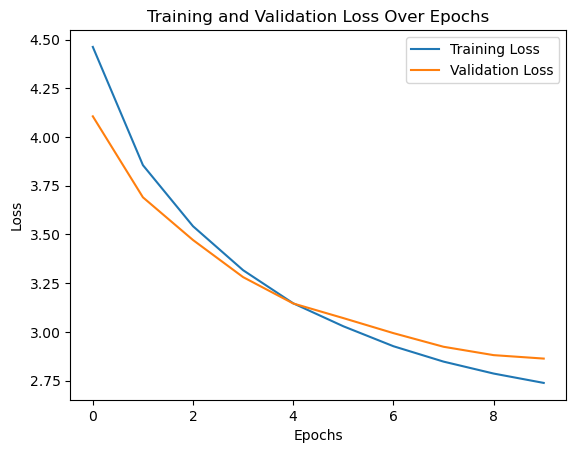

In [45]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
# predicts = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))

1192/1192 [==============================] - 31s 25ms/step


In [5]:
# predicted_classes = np.argmax(predicts, axis = 1)
# predicted_classes

NameError: name 'predicts' is not defined